0.23.4
Joined bars
[301, 246, 154, 89, 35, 18]
Max bars
[395, 331, 236, 164, 72, 38]


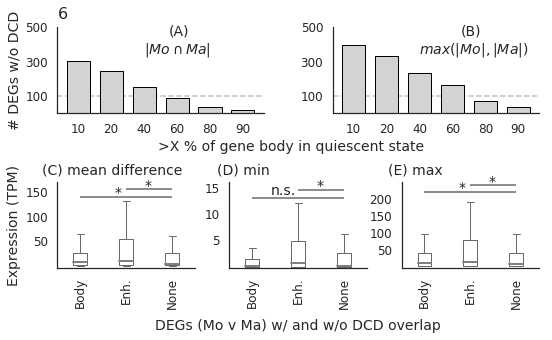

In [1]:
%matplotlib inline

import os as os
import csv as csv
import collections as collect
import operator as op
import itertools as itt
import pickle as pck
import time as ti
import json as js

import matplotlib as mpl
import matplotlib.gridspec as mgs
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import numpy as np
import numpy.random as rng
import scipy.stats as stats
from scipy.stats import mannwhitneyu as mwu
import sklearn as skl
import sklearn.metrics as sklm
import pandas as pd
from pandas.errors import EmptyDataError
import seaborn as sns

# What does this do?
# Plot scatter for mean absolute
# difference in TPM for DE genes
# relative to fc

date = '20180922'

run_bgcov_tpm_diff = True

save_figures = True
diss_version = False

sns.set(style='white',
        font_scale=1.5,
        rc={'font.family': ['sans-serif'],
            'font.sans-serif': ['DejaVu Sans']})

np.seterr('raise')

journal = 'bmc_genbio'
res = 'print_lo'
fig_sizes = js.load(open('/home/pebert/work/code/mpggit/statediff/annotation/misc/fig_sizes.json'))
fig_sizes = fig_sizes[journal]
resolution = fig_sizes['resolution']

scorings = ['penem', 'ordem', 'penrep', 'ordrep']
segmentations = ['cmm18', 'ecs18', 'ecs10']

fhgfs_base = '/TL/deep/fhgfs/projects/pebert/thesis/projects/statediff'
cache_dir = os.path.join(fhgfs_base, 'caching/notebooks')

agg_tpm_file = os.path.join(fhgfs_base, 'salmon', 'deep', 'agg_gene_tpm.h5')
utr_len_file = os.path.join(fhgfs_base, 'references', '20180727_BioMart_ENSv78_UTRs.h5')
tscan_file = os.path.join(fhgfs_base, 'references', 'TargetScan_v7.2_default.h5')

base_out = '/TL/epigenetics2/work/pebert/cloud/mpiinf/phd/chapter_projects/statediff'

fig_supp = os.path.join(base_out, 'figures', 'pub', 'supp')
fig_main = os.path.join(base_out, 'figures', 'pub', 'main')
fig_collect = os.path.join(base_out, 'figures', 'pub', 'collection')
fig_diss = '/home/pebert/work/code/mpggit/dissertation/Figures/diffchrom'


def add_diff_tpm_info(s1, s2, data, degenes):
    
    with pd.HDFStore(agg_tpm_file, 'r') as hdf:
        s1_exp = hdf['gene_tpm/' + s1]
        s2_exp = hdf['gene_tpm/' + s2]
        s1_exp[s1] = s1_exp.mean(axis=1)
        s2_exp[s2] = s2_exp.mean(axis=1)
        joined = pd.concat([s1_exp, s2_exp], ignore_index=False,
                           axis=1, sort=True)
        joined['mean_diff'] = (joined[s1] - joined[s2]).abs()
        joined = joined.loc[joined.index.isin(degenes), ['mean_diff']]
        
    data = pd.concat([data, joined], axis=1,
                     ignore_index=False, sort=True)
    assert not pd.isnull(data).any().any(), 'Missing data'
    return data


def select_plot_groups(data):
    
    select = np.logical_or(data['body_hit'] > 0, data['prom_hit'] > 0)
    body_group = data.loc[select, :].index
    
    select = np.logical_and(~data.index.isin(body_group), data['total_hits'] > 0)
    enh_group = data.loc[select, :].index
    
    select = np.logical_and(~data.index.isin(body_group), data['total_hits'] == 0)
    nohit_group = data.loc[select, :].index
    
    return body_group, enh_group, nohit_group


def plot_tpm_boxes(data, xlabel, ylabel, val_type, ax, pk):
    
    ylim_lut = {'mean_diff': (-5, 170),
                'min_tpm': (-0.25, 16),
                'max_tpm': (-5, 250)}
    ytick_lut = {'mean_diff': [50, 100, 150],
                 'min_tpm': [5, 10, 15],
                 'max_tpm': [50, 100, 150, 200]}
    hlines_lut = {'mean_diff': ([155, 140], [[2, 3], [1, 3]]),
                  'min_tpm': ([14.5, 13], [[2, 3], [1, 3]]),
                  'max_tpm': ([240, 220], [[2, 3], [1, 3]])}
    
    boxcolor = 'dimgrey'
    medcolor = 'grey'
    median_props = {'color': medcolor, 'linewidth': 2}
    box_props = {'color': boxcolor, 'linewidth': 1}
    whisker_props = {'color': boxcolor, 'linewidth': 1}
    cap_props = {'color': boxcolor, 'linewidth': 1}
    
    b, e, n = select_plot_groups(data)
    # body hit
    b = data.loc[b, val_type].values
    # enhancer hit
    e = data.loc[e, val_type].values
    # no hit
    n = data.loc[n, val_type].values
            
    boxes = ax.boxplot([b, e, n], sym="", labels=None,
                       medianprops=median_props, boxprops=box_props,
                       whiskerprops=whisker_props, capprops=cap_props)
        
    y_limits = ylim_lut[val_type]
    ax.set_ylim(*y_limits)
    y_ticks = ytick_lut[val_type]
    
    if ylabel is not None:
        ax.set_ylabel(ylabel, fontsize=14)
    ax.set_yticks(y_ticks)
    ax.set_yticklabels(map(str, y_ticks), fontsize=12)
    
    hl_y, hl_x = hlines_lut[val_type]
    for hy, hx, (p1, p2) in zip(hl_y, hl_x, [(e, n), (b, n)]):
        pv = mwu(p1, p2, alternative='two-sided')[1] * 2
        pv_lab = '*' if pv < 0.01 else 'n.s.'
        if pv_lab != 'n.s.':
            ax.hlines(hy, hx[0], hx[1], color='dimgrey')
            if hx[1] - hx[0] <= 1:
                ax.text(hx[0] + 0.4, hy,
                        pv_lab, fontdict={'fontsize': 14})
            else:
                ax.text(hx[0] + 0.75, hy,
                        pv_lab, fontdict={'fontsize': 14})
        else:
            ax.hlines(hy, hx[0], hx[1], color='dimgrey')
            ax.text(hx[0] + 0.4, hy + 0.55,
                    pv_lab, fontdict={'fontsize': 14})
            
        
    ax.set_xticklabels(['Body', 'Enh.', 'None'],
                       fontsize=12, rotation=90)
    if xlabel is not None:
        ax.set_xlabel(xlabel, fontsize=14, labelpad=10)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    tt = ax.set_title(pk, fontsize=14)
    if pk.startswith('(C)'):
        tt.set_position((0.4, 1.02))
    else:
        tt.set_position((0.1, 1.02))
            
    return ax 
    

def plot_quiet_dist(s1, s2, smp1, smp2, ax_left, ax_right, key_left, key_right, fig_key):
    
    x_pos = [1, 2, 3, 4, 5, 6]
    
    limits = [0.1, 0.2, 0.4, 0.6, 0.8, 0.9]
    joined_bars = []
    max_bars = []
    for l in limits:
        sub1 = set(s1.loc[s1[18] > l, :].index)
        sub2 = set(s2.loc[s2[18] > l, :].index)
        isect = len(sub1.intersection(sub2))
        joined_bars.append(isect)
        max_bars.append(max(len(sub1), len(sub2)))
    print('Joined bars')
    print(joined_bars)
    print('Max bars')
    print(max_bars)
    ax_left.bar(x_pos, joined_bars, color='lightgrey',
                edgecolor='black', align='center', width=0.7)
    
    ax_right.bar(x_pos, max_bars, color='lightgrey',
                 edgecolor='black', align='center', width=0.7)
    
    ax_left.spines['top'].set_visible(False)
    ax_left.spines['right'].set_visible(False)
    ax_left.axhline(100, 0, 1, color='darkgrey', alpha=0.7, ls='dashed', zorder=0)
    yticks = [100, 300, 500]
    ax_left.set_yticks(yticks)
    ax_left.set_yticklabels(map(str, yticks), fontsize=12)
    ax_left.set_ylabel('# DEGs w/o DCD'.format(s1.shape[0]), fontsize=14)
    ax_left.set_xticks(x_pos)
    ax_left.set_xticklabels(['10', '20', '40', '60', '80', '90'], fontsize=12)
    
    ax_left.text(3, 350, r'$\vert {} \cap {} \vert$'.format(smp1, smp2),
              fontsize=14)
    ax_left.text(3.75, 450, key_left, fontsize=14)
    if fig_key is not None:
        tt = ax_left.set_title(fig_key, fontsize=16)
        tt.set_position((0.025, 1.025))
    
    ax_right.spines['top'].set_visible(False)
    ax_right.spines['right'].set_visible(False)
    ax_right.axhline(100, 0, 1, color='darkgrey', alpha=0.7, ls='dashed', zorder=0)
    
    ax_right.set_xticks(x_pos)
    ax_right.set_xticklabels(['10', '20', '40', '60', '80', '90'], fontsize=12)
    ax_right.set_yticks(yticks)
    ax_right.set_yticklabels(map(str, yticks), fontsize=12)
    
    ax_right.text(3, 350, r'$max(\vert {} \vert , \vert {} \vert)$'.format(smp1, smp2),
                  fontsize=14)
    ax_right.text(4.25, 450, key_right, fontsize=14)
    
    tt = ax_right.set_xlabel('>X % of gene body in quiescent state'.format(s1.shape[0]), fontsize=14)
    tt.set_position((-0.2, -0.025))

    return ax_left, ax_right


def make_gridspec_plot(expdata, s1_states, s2_states, s1, s2, fk, save_diss):
    
    fig = plt.figure(figsize=fig_sizes['two_col']['square'])
    widths = [2, 3, 1.5]
    heights = [1, 3, 2]
    gs = mgs.GridSpec(ncols=3, nrows=2, figure=fig, hspace=0.8)
    
    gs.update(left=0, right=1, bottom=0.5, top=1)
    gs.set_width_ratios([1.55, 0, 1.55])
    gs.set_height_ratios([1., 1.])
    
    top_left = fig.add_subplot(gs[0, 0])
    top_right = fig.add_subplot(gs[0, 2])
    
    if save_diss:
        fk = None
    top_left, top_right = plot_quiet_dist(s1_states, s2_states, s1, s2,
                                          top_left, top_right, '(A)', '(B)', fk)
        
    # lower part of plot
    gs.update(left=0, right=1, bottom=0, top=0.5, wspace=0.25)
    gs.set_width_ratios([1, 1, 1])
    gs.set_height_ratios([1., 1.])
    xlabel = 'DEGs ({} v {}) w/ and w/o DCD overlap'.format(s1, s2)
    
    bot_left = fig.add_subplot(gs[1, 0])
    tpm_diff_ylabel = 'Expression (TPM)'
    bot_left = plot_tpm_boxes(expdata, None, tpm_diff_ylabel,
                              'mean_diff', bot_left, '(C) mean difference')
    
    bot_mid = fig.add_subplot(gs[1, 1])
    tpm_min_ylabel = 'Min expr. (TPM)'
    bot_mid = plot_tpm_boxes(expdata, xlabel, None,
                             'min_tpm', bot_mid, '(D) min')
    
    bot_right = fig.add_subplot(gs[1, 2])
    tpm_max_ylabel = 'Max expr. (TPM)'
    bot_right = plot_tpm_boxes(expdata, None, None,
                               'max_tpm', bot_right, '(E) max')

    return fig, []


def load_state_cache(cache_path):
    
    seg = 'cmm18'
    scoring = 'penem'
    with pd.HDFStore(cache_path, 'r') as hdf:
        cached_keys = list(hdf.keys())
        cached_comp = set([k.split('/')[3] for k in cached_keys])
        for comp in cached_comp:
            if comp != 'Mo_vs_Ma':
                continue
            s1, s2 = comp.split('_vs_')
            root_path = os.path.join(seg, scoring, comp)
            # by construction, these are already sorted
            s1_states = hdf[os.path.join(root_path, s1)]
            s2_states = hdf[os.path.join(root_path, s2)]
    return s1_states, s2_states


def load_expression_cache(cache_path):
    
    seg = 'cmm18'
    score = 'penem'
    with pd.HDFStore(cache_path, 'r') as hdf:
        load_keys = sorted([k for k in hdf.keys() if seg in k and score in k])
        for k in load_keys:
            comp = os.path.split(k)[-1]
            if comp != 'Mo_vs_Ma':
                continue
            s1, s2 = comp.split('_vs_')
            data = hdf[k]
            data = data.loc[data['is_de'] == 1, :].copy()
            data = add_diff_tpm_info(s1, s2, data, set(data.index))
    return data, s1, s2


def plot_bgcov_tpm_diff():
    caching_date = '20180921'
    # use cached data from other notebooks
    hsp_ovl_cache = os.path.join(cache_dir, '{}_plot_gene-enh-hsp_tpm-bin.h5'.format(caching_date))
    if not os.path.isfile(hsp_ovl_cache):
        raise RuntimeError('No cached data for HSP overlaps')
        
    state_cache = os.path.join(cache_dir, '{}_plot_deg_state_conf.h5'.format(caching_date))
    if not os.path.isfile(state_cache):
        raise RuntimeError('No cached state data available')
    
    exp_data, s1, s2 = load_expression_cache(hsp_ovl_cache)
    
    s1_states, s2_states = load_state_cache(state_cache)
    
    seg, score = 'cmm18', 'penem'
    comp = 'Mo_vs_Ma'
    fk = '6'
    fig, exart = make_gridspec_plot(exp_data, s1_states, s2_states, s1, s2, fk, diss_version)

    if save_figures:
        outname = 'fig_{}_bgcov_tpm-diff_{}_{}_{}'.format(fk, seg, score, comp)
        out_folder = fig_main
        if diss_version:
            out_folder = fig_diss

        out_pdf = os.path.join(out_folder, outname + '.pdf')
        fig.savefig(out_pdf, bbox_inches='tight', extra_artists=exart)

        if not diss_version:
            out_png = os.path.join(out_folder, outname + '.png')
            fig.savefig(out_png, bbox_inches='tight', extra_artists=exart, dpi=resolution[res])                
    return


if run_bgcov_tpm_diff:
    plot_bgcov_tpm_diff()
